<a href="https://colab.research.google.com/github/chaehchaeh/MajorAI-DL/blob/main/221103DL7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###원핫 인코딩: 0또는 1로 분류

###로그 소프트 맥스 함수: 소프트맥스 함수에 로그를 취한 형태
음의 가능도(negative log likelihood;NLL)손실함수: 로그 소프트맥스 함수 결과에 대한 교차 엔트로피


###confusion matrix(혼동행렬)
ex) true_3,pred_2위치에 6은 참값이 3인데 2로 예측한 경우


In [ ]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [ ]:
#데이터 셋 불러오기
train=datasets.MNIST(
    '../data',train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test=datasets.MNIST(
    '../data',train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        ]),
    )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



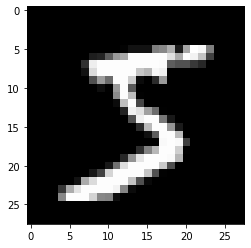

In [ ]:
#이미지 시각화
def plot(x):
    img=(np.array(x.detach().cpu(),dtype='float')).reshape(28,28)

    plt.imshow(img,cmap='gray')
    plt.show()

plot(train.data[0])

In [ ]:
#학습데이터 벡터로 변환
x=train.data.float()/255.
y=train.targets

x=x.view(x.size(0),-1)
print(x.shape,y.shape)

#입출력 데이터 크기 설정
input_size=x.size(-1)
output_size=int(max(y))+1

print('input_size:%d,output_size:%d'% (input_size,output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size:784,output_size:10


In [ ]:
#학습 검증 데이터 분리
ratios=[.8,.2]

train_cnt=int(x.size(0)*ratios[0])
valid_cnt=int(x.size(0)*ratios[1])
test_cnt=len(test.data)
cnts=[train_cnt, valid_cnt]

print("Train%d/Valid%d/Test%d samples."%(train_cnt,valid_cnt,test_cnt))
indices=torch.randperm(x.size(0))
x=torch.index_select(x,dim=0,index=indices)
y=torch.index_select(y,dim=0,index=indices)

x=list(x.split(cnts,dim=0))
y=list(y.split(cnts,dim=0))

x+=[(test.data.float()/255.).view(test_cnt,-1)]
y+=[test.targets]
for x_i,y_i in zip(x,y):
    print(x_i.size(),y_i.size())

Train48000/Valid12000/Test10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [ ]:
#심층신경망 구성

model=nn.Sequential(
    nn.Linear(input_size,500),
    nn.LeakyReLU(),
    nn.Linear(500,400),
    nn.LeakyReLU(),
    nn.Linear(400,300),
    nn.LeakyReLU(),
    nn.Linear(300,200),
    nn.LeakyReLU(),
    nn.Linear(200,100),
    nn.LeakyReLU(),
    nn.Linear(100,50),
    nn.LeakyReLU(),
    nn.Linear(50,output_size),
    nn.LogSoftmax(dim=-1),
)

In [ ]:
#옵티마이저 및 손실함수 설정
optimizer=optim.Adam(model.parameters())
crit=nn.NLLLoss()

#GPU활용 가능여부 판정
device=torch.device('cpu')
if torch.cuda.is_available():
    device=torch.device('cuda')

#모델과 텐서를 선택된 장치로 각각 이동 및 복사
model=model.to(device)
x=[x_i.to(device) for x_i in x]
y=[y_i.to(device) for y_i in y]

In [ ]:
#하이퍼 파라미터 설정
n_epochs=1000
batch_size=256
print_interval=10

lowest_loss=np.inf
best_model=None

early_stop=50
lowest_epoch=np.inf

In [ ]:
#학습시작
train_history,valid_history=[],[]
for i in range(n_epochs):
    indices=torch.randperm(x[0].size(0)).to(device)
    x_=torch.index_select(x[0],dim=0,index=indices)
    y_=torch.index_select(y[0],dim=0,index=indices)

    x_=x_.split(batch_size,dim=0)
    y_=y_.split(batch_size,dim=0)
    train_loss,valid_loss=0,0
    y_hat=[]

    for x_i,y_i in zip(x_,y_):
        y_hat_i=model(x_i)
        loss=crit(y_hat_i,y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss+=float(loss)

    train_loss=train_loss/len(x_)
#검증
    with torch.no_grad():
        x_hat_i=model(x_i)
        loss=crit(y_hat_i,y_i.squeeze())
        valid_loss+=float(loss)

        y_hat+=[y_hat_i]

    valid_loss=valid_loss/len(x_)

    train_history+=[train_loss]
    valid_history+=[valid_loss]

    if(i+1)%print_interval==0:
        print('Epoch%d: train loss=%.4e valid_loss=%.4e lowest_loss=%.4e'%
              (i+1,train_loss,valid_loss,lowest_loss,))
#조기종료 및 베스트 모델 선택
    if valid_loss<=lowest_loss:
        lowest_loss=valid_loss
        lowest_epoch=i

        best_model=deepcopy(model.state_dict())
    else:
        if early_stop>0 and lowest_epoch+early_stop<i+1:
            print("There is no improvement during last %d epochs."% early_stop)
            break

print("The best validation loss from epoch %d: %.4e"% (lowest_epoch+1, lowest_loss))
model.load_state_dict(best_model)

Epoch10: train loss=2.4878e-02 valid_loss=4.6140e-04 lowest_loss=4.4256e-05
Epoch20: train loss=1.1289e-02 valid_loss=2.0678e-06 lowest_loss=4.9462e-06
Epoch30: train loss=9.0956e-03 valid_loss=7.6103e-07 lowest_loss=2.0678e-06
Epoch40: train loss=6.0677e-03 valid_loss=6.1074e-06 lowest_loss=4.3670e-07
Epoch50: train loss=4.5913e-03 valid_loss=5.0413e-05 lowest_loss=1.5595e-07
Epoch60: train loss=7.9772e-04 valid_loss=6.5363e-08 lowest_loss=5.1819e-08
Epoch70: train loss=8.9736e-07 valid_loss=6.5189e-09 lowest_loss=1.5852e-10
Epoch80: train loss=1.3654e-07 valid_loss=8.9169e-11 lowest_loss=1.4862e-11
Epoch90: train loss=2.3716e-08 valid_loss=4.9538e-12 lowest_loss=1.4862e-11
Epoch100: train loss=5.1743e-09 valid_loss=0.0000e+00 lowest_loss=0.0000e+00
Epoch110: train loss=1.3796e-09 valid_loss=9.9077e-12 lowest_loss=0.0000e+00
Epoch120: train loss=4.3098e-10 valid_loss=0.0000e+00 lowest_loss=0.0000e+00
Epoch130: train loss=1.6843e-10 valid_loss=0.0000e+00 lowest_loss=0.0000e+00
Epoch140

KeyboardInterrupt: ignored

In [ ]:
#손실곡선 확인
plot_from=0

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train/Valid Loss History")
plt.plot(
    range(plot_from. len(train_history)), train_history[plot_from:],
    range(plot_from. len(train_history)), valid_history[plot_from:],
    )
plt.yscale('log')
plt.show()

In [ ]:
#평가(테스트):검증코드와 비슷함
test_loss=0
y_hat=[]

with torch.no_grad():
    x_=

In [ ]:
#분류 정확도 계산
correct_cnt=(y[-1].squeeze()==torch.argmax(y_hat,dim=-1)).sum()
total_cnt=float(y[-1].size(0))

In [ ]:
#혼동행렬 출력
import pandas as pd
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y[-1],torch.argmax(y_hat,dim=1)),
             index=['true_%d % i for i in range(10),
             columns=['pred_%d' % i for i in range(10)]]
             )